In [1]:
import os
import random
import shutil
from threading import Thread
from PIL import Image
import numpy as np
from tqdm import tqdm

PALLETE = {(0, 0, 142): 0,
           (45, 60, 150): 1,
           (70, 70, 70): 2,
           (70, 130, 180): 3,
           (81, 0, 81): 4,
           (100, 40, 40): 5,
           (102, 102, 156): 6,
           (107, 142, 35): 7,
           (110, 190, 160): 8,
           (128, 64, 128): 9,
           (145, 170, 100): 10,
           (150, 100, 100): 11,
           (153, 153, 153): 12,
           (157, 234, 50): 13,
           (170, 120, 50): 14,
           (220, 220, 0): 15,
           (230, 150, 140): 16,
           (244, 35, 232): 17,
           (250, 170, 30): 18
           }


def iSAID_convert_from_color(arr_3d, palette=PALLETE):
    """RGB-color encoding to grayscale labels."""
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)
    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i
    return arr_2d


PATH = f'../data/town/'

new_dataset_path = os.path.join('../data', 'formatted_dataset')
os.mkdir(new_dataset_path)

img_dir = os.path.join(new_dataset_path, 'img_dir')
ann_dir = os.path.join(new_dataset_path, 'ann_dir')

os.mkdir(img_dir)
os.mkdir(ann_dir)

new_dataset_train_path_img = os.path.join(img_dir, 'train')
new_dataset_test_path_img = os.path.join(img_dir, 'test')
new_dataset_val_path_img = os.path.join(img_dir, 'val')
os.mkdir(new_dataset_train_path_img)
os.mkdir(new_dataset_test_path_img)
os.mkdir(new_dataset_val_path_img)

new_dataset_train_path_ann = os.path.join(ann_dir, 'train')
new_dataset_test_path_ann = os.path.join(ann_dir, 'test')
new_dataset_val_path_ann = os.path.join(ann_dir, 'val')
os.mkdir(new_dataset_train_path_ann)
os.mkdir(new_dataset_test_path_ann)
os.mkdir(new_dataset_val_path_ann)

towns_path = os.listdir(PATH)


def save_images(town_path, waypoint):
    waypoint_path = os.path.join(town_path, waypoint)
    images_path = os.path.join(waypoint_path, 'rgb')
    masks_path = os.path.join(waypoint_path, 'seg')
    image_list = os.listdir(images_path)
    for image in image_list:
        train_test_val = random.randint(0, 10)
        new_image_name = image.replace('_rgb', '')
        new_image_name = new_image_name.replace('.', '_img.')

        if train_test_val <= 7:
            copy_path_img = new_dataset_train_path_img
            copy_path_ann = new_dataset_train_path_ann
        elif train_test_val <= 9:
            copy_path_img = new_dataset_test_path_img
            copy_path_ann = new_dataset_test_path_ann
        else:
            copy_path_img = new_dataset_val_path_img
            copy_path_ann = new_dataset_val_path_ann

        shutil.copy2(os.path.join(images_path, image), os.path.join(copy_path_img, new_image_name))
        seg_file = image.replace('rgb', 'seg')
        seg_file = seg_file.replace('.', '_color.')
        new_seg_name = new_image_name.replace('_img', '_mask')
        mask = Image.open(os.path.join(masks_path, seg_file))
        mask = np.array(mask)[:, :, :3]
        mask = iSAID_convert_from_color(mask)
        Image.fromarray(mask).save(os.path.join(copy_path_ann, new_seg_name))


def start(count: int = 4):
    for town_name in towns_path:
        town_path = os.path.join(PATH, town_name)
        waypoints = os.listdir(town_path)
        count_wps = int(np.ceil(len(waypoints) / count))
        with tqdm(total=count_wps) as t:
            for i in range(count_wps):
                procs = list()
                for j in range(count):
                    if i * count + j >= len(waypoints):
                        break
                    procs.append(Thread(target=save_images, args=(town_path, waypoints[i + count + j],)))

                for proc in procs:
                    proc.start()

                for proc in procs:
                    proc.join()

                t.set_description_str(f'Town: {town_name}')
                t.update(1)


In [2]:
start(count=8)

Town: Town10: 100%|██████████| 14/14 [04:54<00:00, 21.06s/it]


In [17]:
from mmcv import Config

cfg = Config.fromfile('config.py')

In [18]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import mmcv
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'flow.ipynb'
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict())

2023-02-06 11:36:13,941 - mmseg - INFO - Loaded 1579 images
C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\mmseg\models\backbones\resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2023-02-06 11:36:14,356 - mmseg - INFO - Loaded 446 images
2023-02-06 11:36:14,357 - mmseg - INFO - Start running, host: Nitcu@Inchore, work_dir: C:\MySpace\Projects\Roads\mmdetection_flow
2023-02-06 11:36:14,358 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 8.00 GiB total capacity; 7.21 GiB already allocated; 0 bytes free; 7.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [21]:
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

PATH = '..\data\\formatted_dataset\\ann_dir\\train'
imgs = os.listdir(PATH)

labels = list()

with tqdm(total=len(imgs)) as t:
    for img in imgs:
        mask = Image.open(os.path.join(PATH, img))
        mask = np.array(mask)
        labels = list(labels)
        labels.extend(list(np.unique(mask)))
        labels = set(labels)
        t.update(1)

100%|██████████| 1117/1117 [00:38<00:00, 29.30it/s]


In [22]:
labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}

In [10]:
import numpy as np

array = np.random.random_integers(0, 255, (20, 20))
list(np.unique(array))

C:\Users\Nitcu\AppData\Local\Temp\ipykernel_60396\3862868976.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead
  array = np.random.random_integers(0, 255, (20, 20))


[1,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 25,
 26,
 27,
 28,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 44,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 82,
 83,
 85,
 87,
 89,
 90,
 91,
 92,
 93,
 96,
 97,
 98,
 99,
 101,
 102,
 103,
 105,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 143,
 144,
 145,
 146,
 147,
 149,
 150,
 151,
 152,
 153,
 154,
 156,
 157,
 158,
 159,
 160,
 162,
 163,
 165,
 166,
 167,
 168,
 171,
 172,
 173,
 174,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 188,
 189,
 190,
 191,
 192,
 194,
 196,
 197,
 199,
 200,
 201,
 202,
 203,
 204,
 206,
 207,
 208,
 209,
 210,
 211,
 213,
 215,
 216,
 217,
 218,
 219,
 221,
 222,
 223,
 224,
 225,
 

In [15]:
from PIL import Image

img = Image.open('C:\\MySpace\\Projects\\Roads\\data\\formatted_dataset\\ann_dir\\train\\2_main_600_0_clear_mask.png')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17]

In [11]:
labels

{(0, 0, 142),
 (45, 60, 150),
 (70, 70, 70),
 (70, 130, 180),
 (81, 0, 81),
 (100, 40, 40),
 (102, 102, 156),
 (107, 142, 35),
 (110, 190, 160),
 (128, 64, 128),
 (145, 170, 100),
 (150, 100, 100),
 (153, 153, 153),
 (157, 234, 50),
 (170, 120, 50),
 (220, 220, 0),
 (230, 150, 140),
 (244, 35, 232),
 (250, 170, 30)}

In [3]:
from mmcv.utils import config
from mmseg.apis import init_segmentor, inference_segmentor


cfg = 'config.py'
ckpt = "checpoints/iter_50000.pth"

cfg = config.Config.fromfile(cfg)

model = init_segmentor(cfg, ckpt)

C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checpoints/iter_50000.pth


In [4]:
model

EncoderDecoder(
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

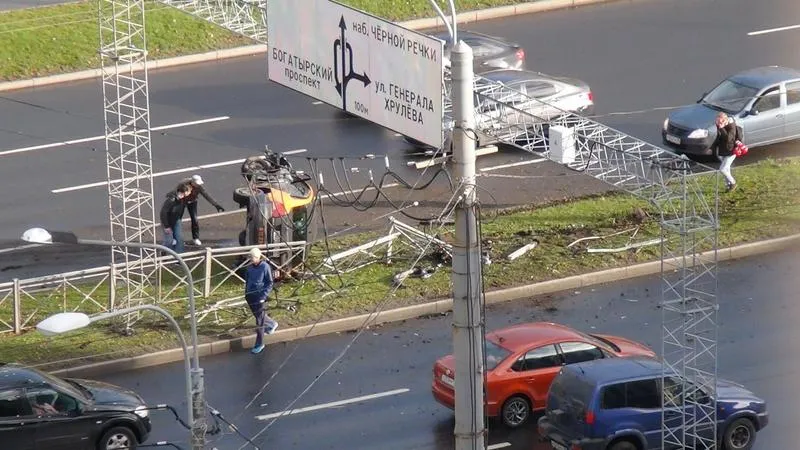

In [102]:
from PIL import Image
import numpy as np
import os

PATH_IMG = 'C:\\MySpace\\datasets\\road_masks\\img_dir\\val'
fn = '22.png'
img = Image.open('C:\\MySpace\\datasets\\разрушенные_ограждения\\новая порция\\1540729586359.jpg').convert('RGB')
img = np.array(img)
img = img[:, :, :3]

Image.fromarray(img)

In [103]:
out = inference_segmentor(model, img)[0]

In [104]:
import torch

out = torch.from_numpy(out)
image = torch.tensor(img, dtype=torch.uint8).permute((2, 0, 1))
out.shape, image.shape

(torch.Size([450, 800]), torch.Size([3, 450, 800]))

In [105]:
out.unique().tolist()

[0, 2, 3, 4]

In [106]:
# Image.fromarray(np.concatenate([
#     np.expand_dims((out*20).numpy(), axis=0),
#     np.expand_dims((out*20).numpy(), axis=0),
#     np.expand_dims((out*20).numpy(), axis=0)]
# , axis=0))

In [107]:
mask = torch.zeros((6, *out.size()))

for i in out.unique().tolist():
    mask[i, out == i] = 1

mask = mask.to(dtype=bool)

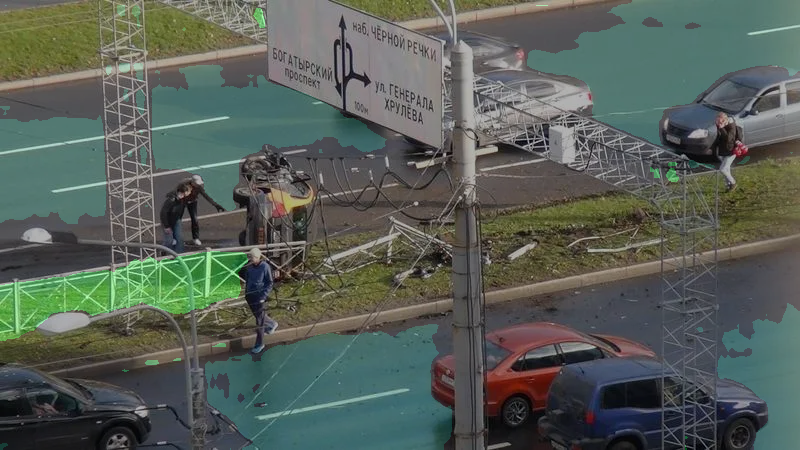

In [108]:
from torchvision.utils import draw_segmentation_masks

segm_image = draw_segmentation_masks(image, mask, alpha=0.3)

segm_image = segm_image.permute((1, 2, 0))
segm_image = segm_image.numpy()

Image.fromarray(segm_image)

In [109]:
Image.fromarray(segm_image).save(f'{fn}')

In [1]:
import cv2
from tqdm import tqdm

cap = cv2.VideoCapture('15.12.2022_08.30.00-15.12.2022_08.31.00 (1).avi')

# Check if camera opened successfully
if (cap.isOpened() == False):
    print("Error opening video stream or file")

# Get current width of frame
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float
# Get current height of frame
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # float

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out_cap = cv2.VideoWriter('output6.avi', fourcc, 30.0, (int(width),int(height)))

cap.set(cv2.CAP_PROP_POS_MSEC, 2000)
def get_mask(pred):
    mask = torch.zeros((6, *pred.size()))

    for i in out.unique().tolist():
        mask[i, out == i] = 1

    return mask.to(dtype=bool)

count = 0
# Read until video is completed
with tqdm(total=1000) as t:
    while (cap.isOpened() or count == 1000):
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            out = inference_segmentor(model, frame)
            out = torch.from_numpy(out[0])
            mask = get_mask(out)
            image = torch.tensor(frame, dtype=torch.uint8).permute((2, 0, 1))
            segm_image = draw_segmentation_masks(image, mask, alpha=0.3)

            segm_image = segm_image.permute((1, 2, 0))
            segm_image = segm_image.numpy()
            # Display the resulting frame
            out_cap.write(segm_image)
            cv2.imshow('frame', segm_image)

            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            count += 1
            t.update(1)

        # Break the loop
        else:
            break

# When everything done, release the video capture object
cap.release()
out_cap.release()
cv2.destroyAllWindows()

  0%|          | 0/1000 [00:00<?, ?it/s]


NameError: name 'inference_segmentor' is not defined

In [12]:
!mim download mmsegmentation --config pspnet_r50-d8_512x1024_40k_cityscapes --dest .

processing pspnet_r50-d8_512x1024_40k_cityscapes...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in C:\MySpace\Projects\Roads\mmdetection_flow
Successfully dumped pspnet_r50-d8_512x1024_40k_cityscapes.py to C:\MySpace\Projects\Roads\mmdetection_flow


In [1]:
from mmseg.apis import init_segmentor, inference_segmentor
from mmcv.utils import config

cfg_cit = 'pspnet_r50-d8_512x1024_40k_cityscapes.py'
ckpt_cit = "pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth"

model_cit = config.Config.fromfile(cfg_cit)

model_cit = init_segmentor(cfg_cit, ckpt_cit)

C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
C:\MySpace\Programs\anaconda3\envs\cvenv\lib\site-packages\mmseg\models\losses\cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


In [111]:
out = inference_segmentor(model, img)

In [112]:
import torch

out = torch.from_numpy(out[0])
image = torch.tensor(img, dtype=torch.uint8).permute((2, 0, 1))
out.shape, image.shape

(torch.Size([1080, 1920]), torch.Size([3, 1080, 1920]))

In [115]:
mask = torch.zeros((19, *out.size()))

for i in out.unique().tolist():
    mask[i, out == i] = 1

mask = mask.to(dtype=bool)

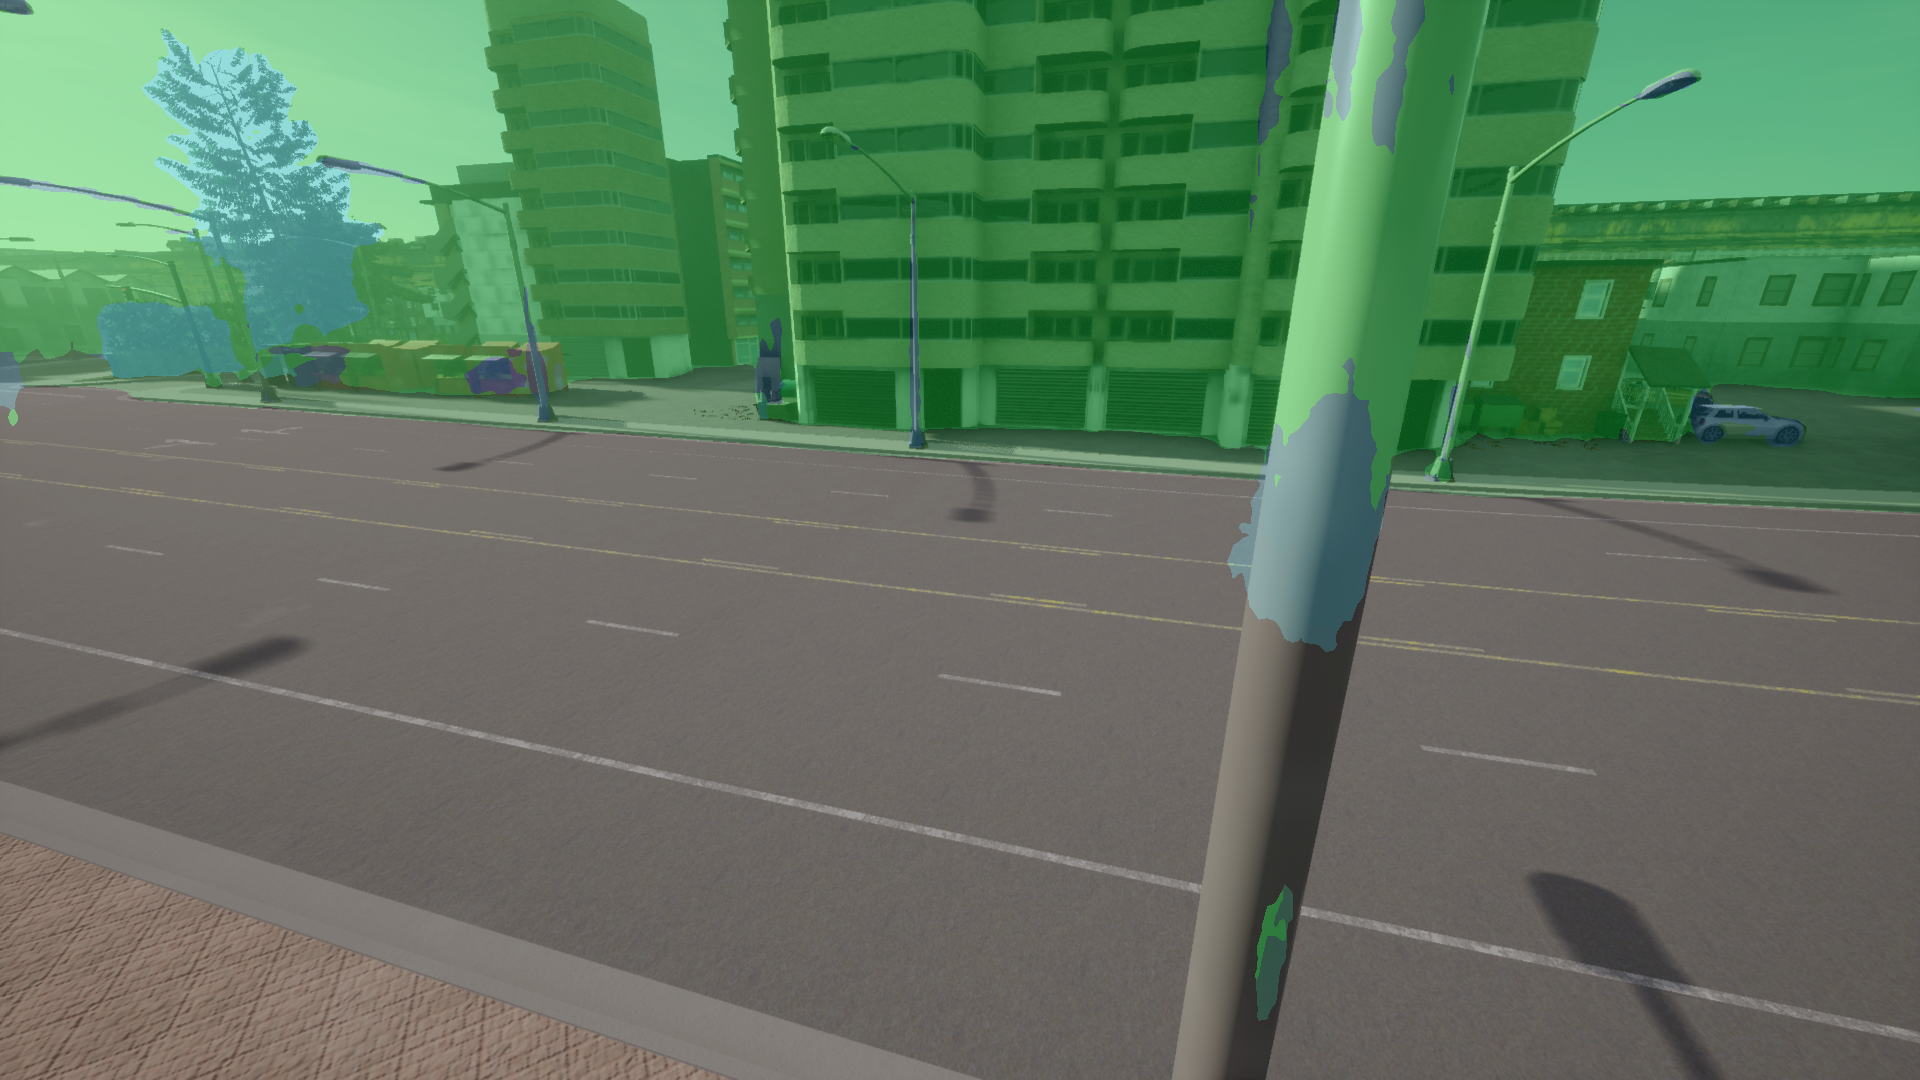

In [116]:
from torchvision.utils import draw_segmentation_masks

segm_image = draw_segmentation_masks(image, mask, alpha=0.3)

segm_image = segm_image.permute((1, 2, 0))
segm_image = segm_image.numpy()

Image.fromarray(segm_image)

In [121]:
import cv2

cap = cv2.VideoCapture('..\\data\\samples\\__31.10.2022__07.00.00-07.00.30.avi')

# Check if camera opened successfully
if (cap.isOpened() == False):
    print("Error opening video stream or file")

cap.set(cv2.CAP_PROP_POS_MSEC, 1000)
def get_mask(pred, filter_labels=()):
    mask = torch.zeros((19, *pred.size()))

    for i in out.unique().tolist():
        mask[i, out == i] = 1

    return mask.to(dtype=bool)

# Read until video is completed
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        out = inference_segmentor(model_cit, frame)
        out = torch.from_numpy(out[0])
        mask = get_mask(out, filter_labels=(9))
        image = torch.tensor(frame, dtype=torch.uint8).permute((2, 0, 1))
        segm_image = draw_segmentation_masks(image, mask, alpha=0.3)

        segm_image = segm_image.permute((1, 2, 0))
        segm_image = segm_image.numpy()
        # Display the resulting frame
        cv2.imshow('Frame', segm_image)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Break the loop
    else:
        break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()